In [2]:
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
import faiss

# 1. Load CLIP Model & Processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. Load Metadata and Image Embeddings
products_df = pd.read_csv("C:/Users/chira/Desktop/Fashion Visual Search & Intelligent Styling Assistant/embedding/valid_products.csv")
embeddings = np.load("C:/Users/chira/Desktop/Fashion Visual Search & Intelligent Styling Assistant/embedding/fashion_image_embeddings.npy")


In [3]:
# 3. Normalize embeddings for cosine similarity
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# 4. Create FAISS index with cosine similarity
index = faiss.IndexFlatIP(normalized_embeddings.shape[1])  # IP = Inner Product
index.add(normalized_embeddings)


In [4]:
# 5. Get embedding for a new image
def get_image_embedding(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        with torch.no_grad():
            features = model.get_image_features(**inputs)
        features = features / features.norm(dim=-1, keepdim=True)
        return features.cpu().numpy()[0]
    except Exception as e:
        print(f"❌ Error fetching image: {e}")
        return None

# 6. Search similar products
def search_similar(image_url, top_k=5, exact_threshold=0.05):
    query_embed = get_image_embedding(image_url)
    if query_embed is None:
        return None

    # Normalize and reshape for FAISS
    query_embed = query_embed / np.linalg.norm(query_embed)
    query_embed = np.expand_dims(query_embed, axis=0)

    distances, indices = index.search(query_embed, top_k)

    results = products_df.iloc[indices[0]].copy()
    results["distance"] = distances[0]
    results["exact_match"] = results["distance"] >= (1 - exact_threshold)  # cosine similarity close to 1
    return results[["pdp_images_s3", "category_type", "image_url", "distance", "exact_match"]]


In [5]:
# 7. Example usage:
image_url = "https://gallery.stylumia.com/originals/2022/12/383/51d412a50238008396b4d8a047d24f2a0a9343447486c48bdfa50e1f59c9545d_1.jpg"  # Replace with your query image
similar_items = search_similar(image_url, top_k=5)

if similar_items is not None:
    print(similar_items)
else:
    print("Failed to retrieve similar items.")

                                           pdp_images_s3 category_type  \
10842  ['https://gallery.stylumia.com/originals/2025/...         dress   
3122   ['https://gallery.stylumia.com/originals/2024/...         dress   
171    ['https://gallery.stylumia.com/originals/2023/...         dress   
2507   ['https://gallery.stylumia.com/originals/2024/...         dress   
2722   ['https://gallery.stylumia.com/originals/2024/...         dress   

                                               image_url  distance  \
10842  https://gallery.stylumia.com/originals/2025/03...  0.926734   
3122   https://gallery.stylumia.com/originals/2024/07...  0.920362   
171    https://gallery.stylumia.com/originals/2023/02...  0.914237   
2507   https://gallery.stylumia.com/originals/2024/06...  0.913937   
2722   https://gallery.stylumia.com/originals/2024/06...  0.913623   

       exact_match  
10842        False  
3122         False  
171          False  
2507         False  
2722         False  


In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def display_similar_results(query_image_url, results_df, top_k=5):
    """
    Display the query image and all images of top-k similar results in a grid.
    """
    from ast import literal_eval

    # Number of rows: one for query, one per result
    n_rows = top_k + 1
    plt.figure(figsize=(20, 3 * n_rows))

    # Display query image first
    try:
        response = requests.get(query_image_url)
        query_img = Image.open(BytesIO(response.content)).convert("RGB")
        ax = plt.subplot(n_rows, 1, 1)
        plt.imshow(query_img)
        plt.axis("off")
        ax.set_title("Query Image", fontsize=12)
    except:
        print("❌ Failed to load query image.")

    # Filter out query image
    unique_results = results_df[results_df["image_url"] != query_image_url].head(top_k)

    # Now plot all images for each result
    for i, (_, row) in enumerate(unique_results.iterrows()):
        try:
            # Parse stringified list safely
            img_urls = literal_eval(row["pdp_images_s3"]) if isinstance(row["pdp_images_s3"], str) else []

            for j, img_url in enumerate(img_urls):
                ax = plt.subplot(n_rows, max(len(img_urls), 1), (i + 1) * max(len(img_urls), 1) + j + 1)
                try:
                    response = requests.get(img_url, timeout=10)
                    img = Image.open(BytesIO(response.content)).convert("RGB")
                    plt.imshow(img)
                    plt.axis("off")
                    if j == 0:
                        ax.set_title(f"{row['category_type']} (Dist: {row['distance']:.2f})", fontsize=9)
                except Exception as e:
                    print(f"❌ Error loading image {j+1} for result {i+1}: {e}")

        except Exception as e:
            print(f"❌ Error parsing pdp_images_s3: {e}")

    plt.tight_layout()
    plt.show()


C:\Users\chira\AppData\Local\Temp\ipykernel_612\3437667745.py:51: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


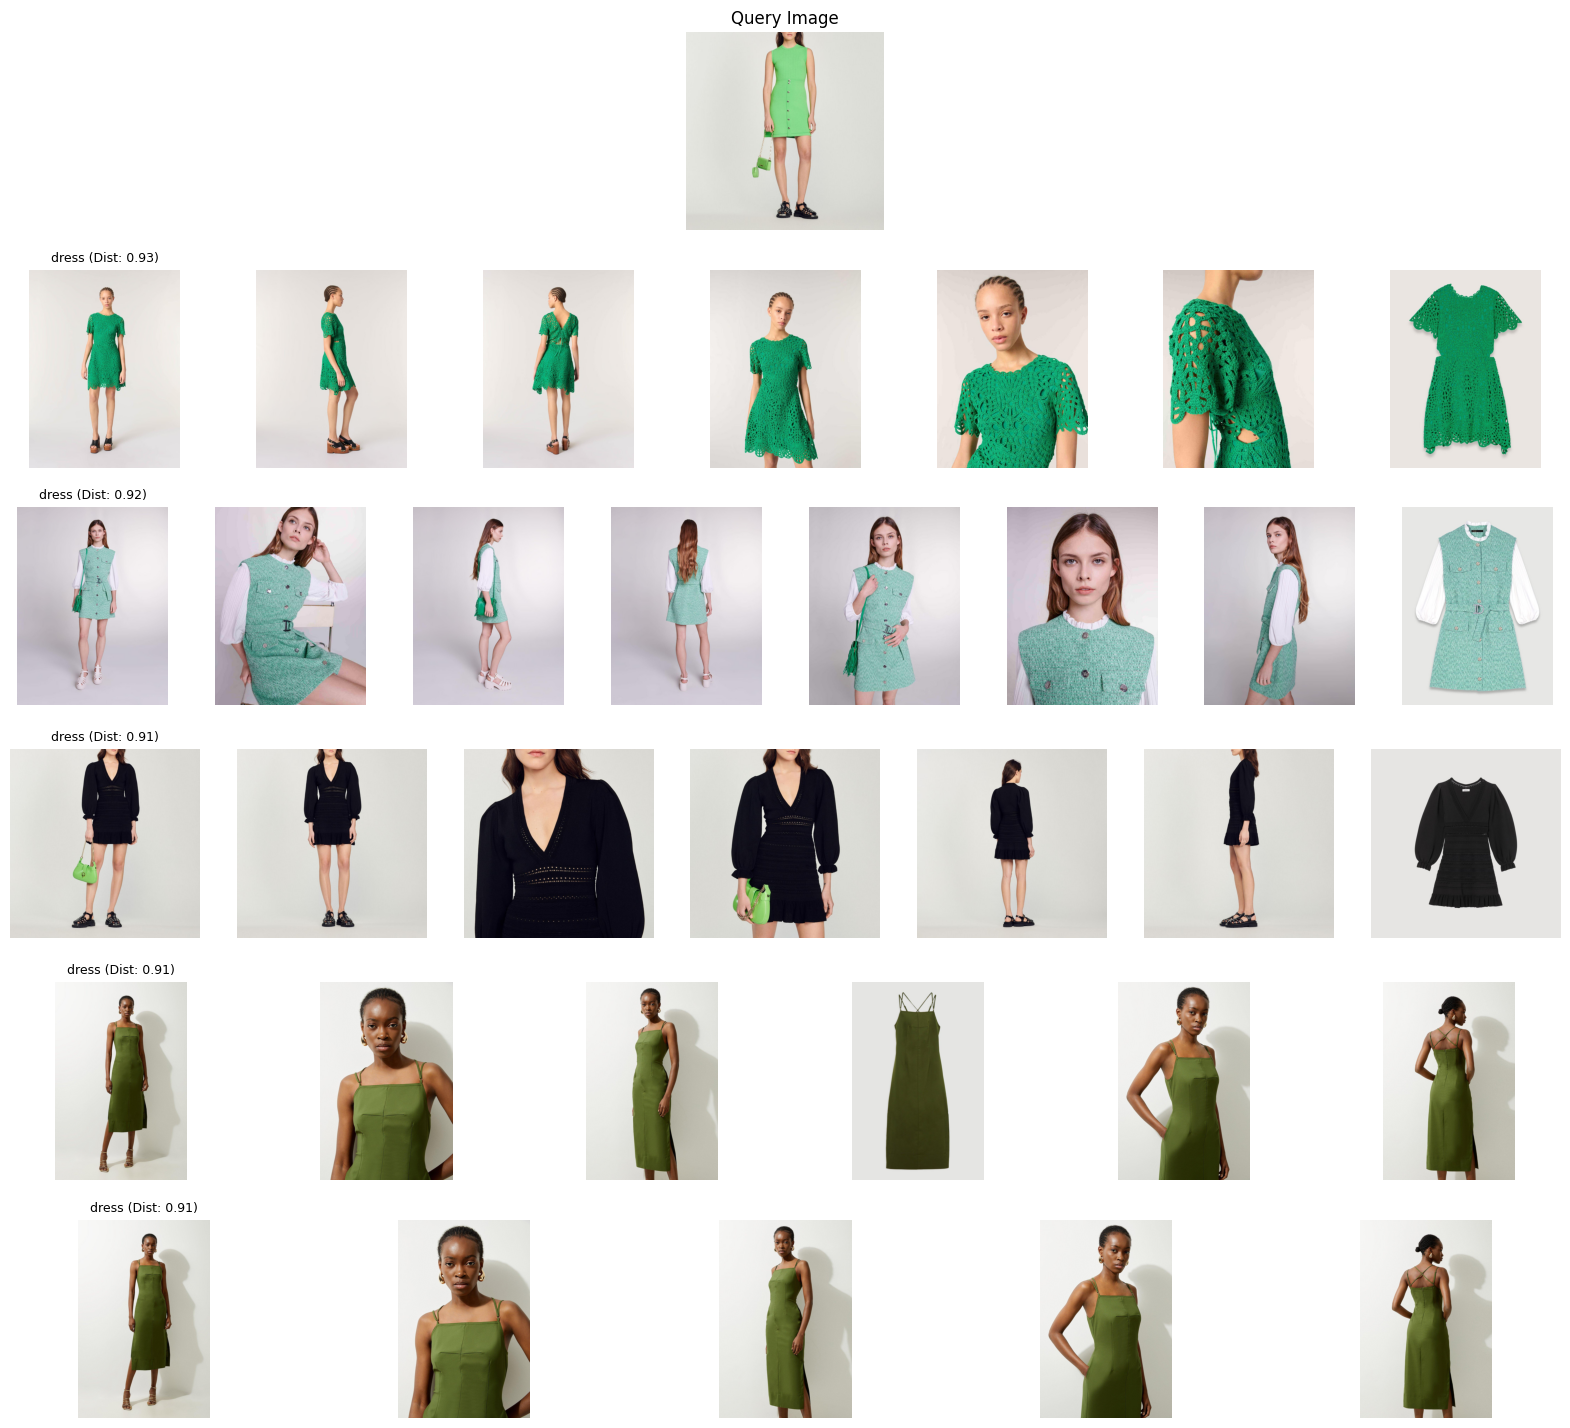

In [15]:
image_url = "https://gallery.stylumia.com/originals/2022/12/383/51d412a50238008396b4d8a047d24f2a0a9343447486c48bdfa50e1f59c9545d_1.jpg"
similar_items = search_similar(image_url, top_k=5)

if similar_items is not None:
    display_similar_results(image_url, similar_items, top_k=5)
else:
    print("Failed to retrieve similar items.")


C:\Users\chira\AppData\Local\Temp\ipykernel_612\3437667745.py:51: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


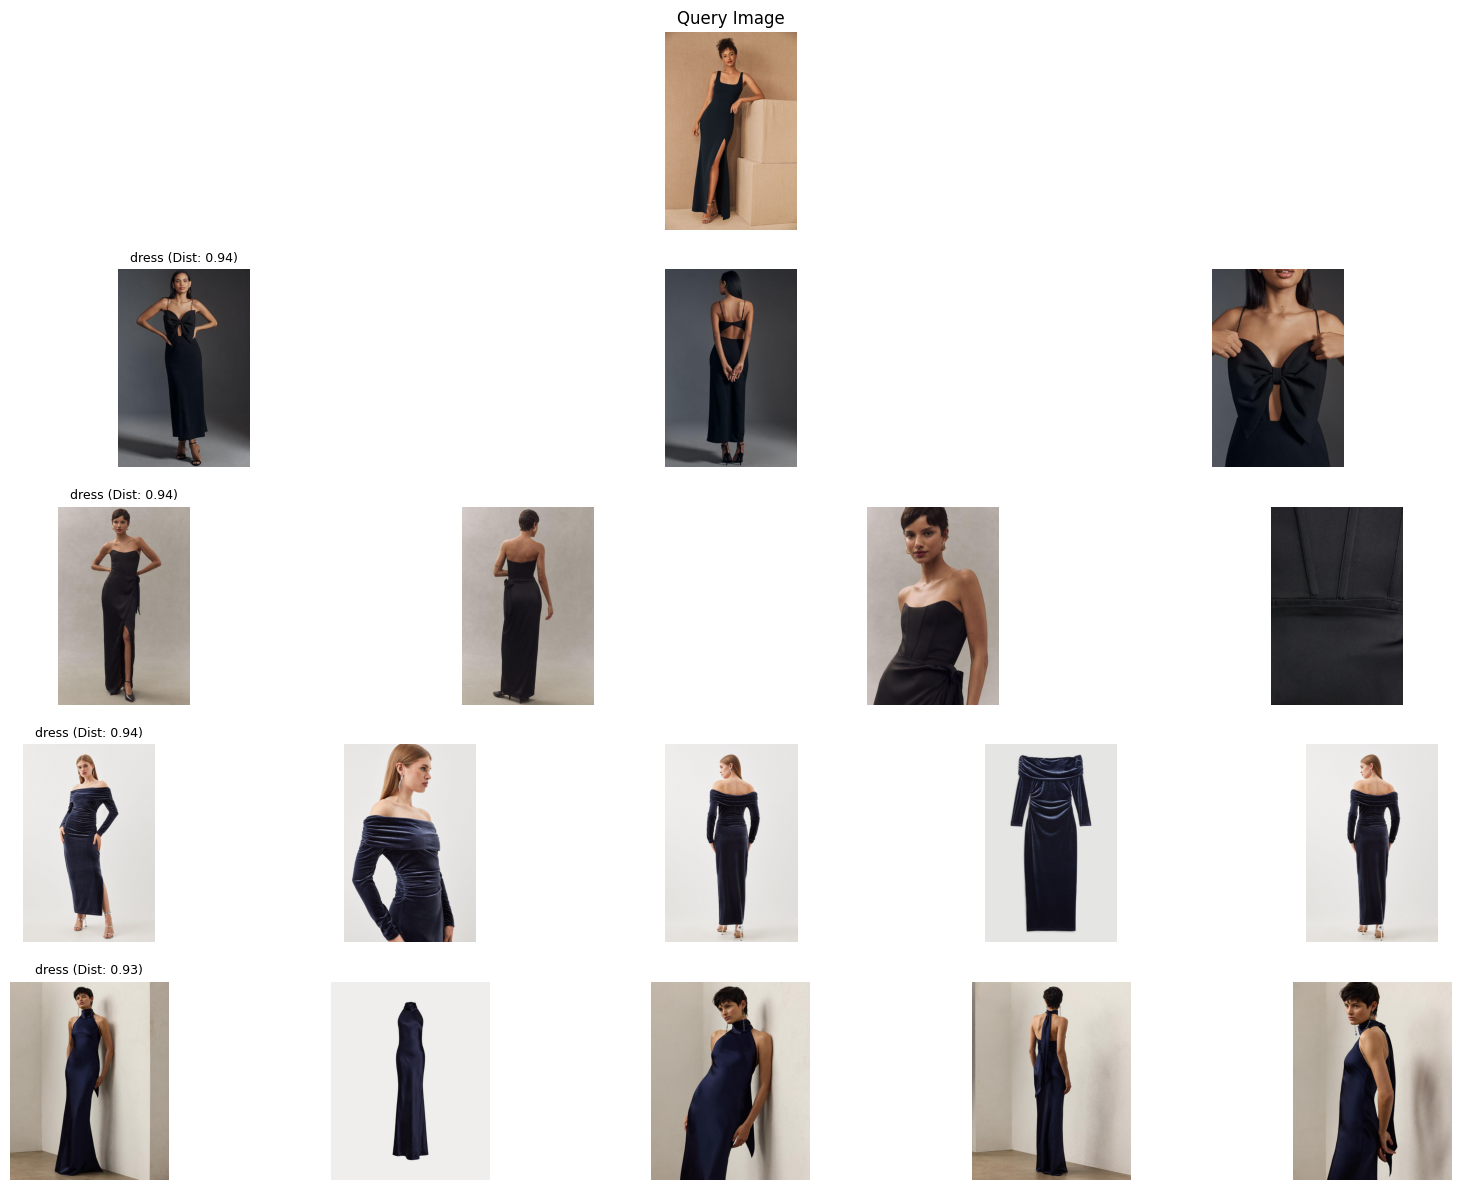

In [16]:
image_url = "https://gallery.stylumia.com/originals/2020/05/48/6360245240b68885bd4dbcef8d8856c0fb13f1314769f5273904a6eac26fb452_1.jpg"
similar_items = search_similar(image_url, top_k=5)

if similar_items is not None:
    display_similar_results(image_url, similar_items, top_k=5)
else:
    print("Failed to retrieve similar items.")


In [3]:
# Run this once in a script or notebook
import faiss
import numpy as np

# Load your saved embeddings
embeddings = np.load("C:/Users/chira/Desktop/fashion-visual-search/app/model/fashion_image_embeddings.npy").astype("float32")

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# Save the index
faiss.write_index(index, "C:/Users/chira/Desktop/fashion-visual-search/app/model/faiss_index.idx")
print("✅ FAISS index saved.")


✅ FAISS index saved.
